<a href="https://colab.research.google.com/github/Colorful-Intelligence/-Biomechanical-feature-of-orthopedic-data-with-KNN/blob/main/EfficientNet_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing Required Libraries

In [ ]:
!pip install  visualkeras
!pip3 install ann_visualizer
!pip install graphviz

     |████████████████████████████████| 795 kB 7.3 MB/s 
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=029fccd7a10de40fd6d0779283c1a3ff12b9422c37fac7eb67b85d66c35d1539
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


# LIBRARIES

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import visualkeras
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Reading the Dataset

In [ ]:
train_path = "/content/drive/MyDrive/CovidDataset2/train/"
test_path = "/content/drive/MyDrive/CovidDataset2/test/"

# Exploratory Data Analysis - 1

In [ ]:
numberOfClass = len(glob(train_path+"/*")) 
print("Number of Class: ",numberOfClass)

Number of Class:  4


# Exploratory Data Analysis - 2 (Sample Images)

In [ ]:
def sampleImage(sampe_image_path):
  img = load_img(train_path + sampe_image_path)
  x = img_to_array(img)
  print(x.shape)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

COVID19

(3480, 4248, 3)


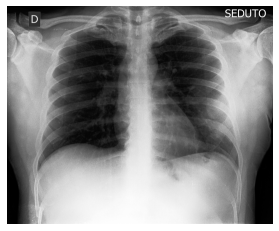

In [ ]:
sample_image_path = "COVID19/02.jpeg"
sampleImage(sample_image_path)

NORMAL

(1066, 1412, 3)


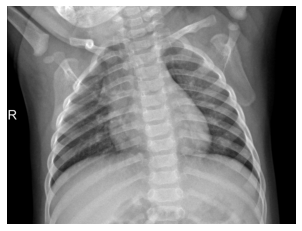

In [ ]:
sample_image_path = "NORMAL/NORMAL2-IM-0749-0001.jpeg"
sampleImage(sample_image_path)

PNEUMONIA

(1066, 1412, 3)


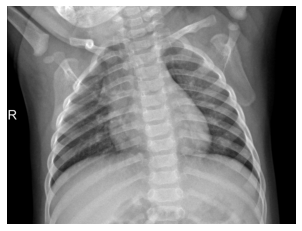

In [ ]:
sample_image_path = "NORMAL/NORMAL2-IM-0749-0001.jpeg"
sampleImage(sample_image_path)

TUBERCULOSIS

(512, 512, 3)


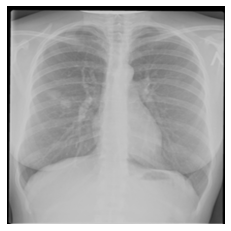

In [ ]:
sample_image_path = "TUBERCULOSIS/Tuberculosis-158.png"
sampleImage(sample_image_path)

As we can see , dimension of every images is different , that is why we must be set each images at same dimension.

# Data Preprocessing

In [ ]:
labels = ['COVID19','NORMAL','PNEUMONIA','TUBERCULOSIS']

In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/CovidDataset2','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/CovidDataset2','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 41/41 [00:10<00:00,  3.74it/s]


# SAMPLE IMAGE FROM EACH LABEL

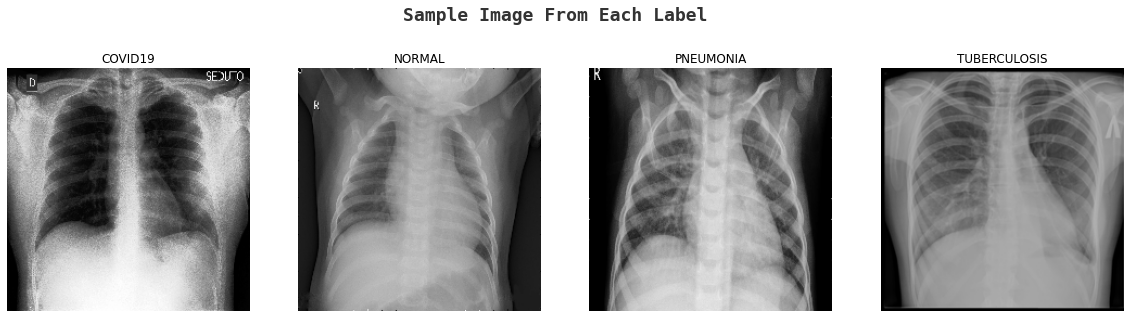

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(2771, 224, 224, 3)

# Dividing the dataset as a Train & Test

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing One Hot Encoding on the labels after converting it into numerical values

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Building EfficientNet

In [ ]:
efficientNet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16719872/16705208 [==============================] - 0s 0us/step


# Layers of the EfficientNet

In [ ]:
efficientNet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

# Visualize of the EfficientNet

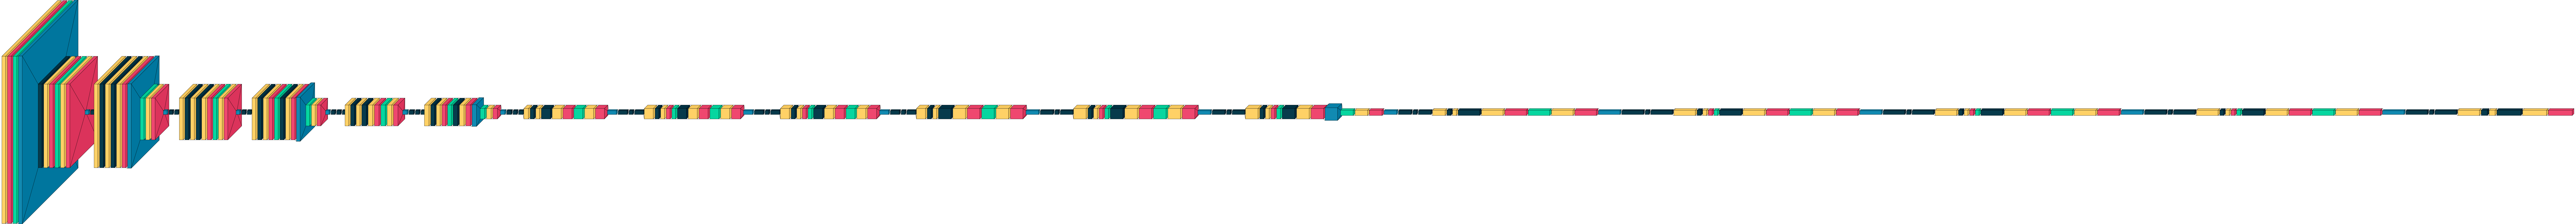

In [ ]:
visualkeras.layered_view(efficientNet)

In [ ]:
model = efficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(numberOfClass,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientNet.input, outputs = model)

Layers of the Model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

# Visualize of the Model

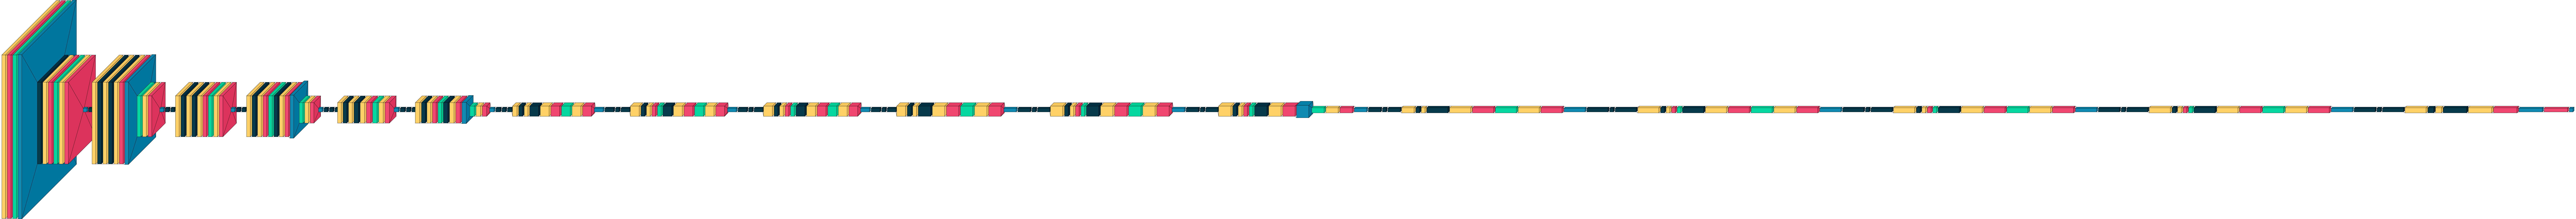

In [ ]:
visualkeras.layered_view(model)

# Compiling the Model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'Adam', 
              metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("CovidModelEfficientNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',verbose=1)

# Training the Model

In [ ]:
hist = model.fit(X_train,
                 y_train,
                 validation_split=0.1, 
                 epochs =15, 
                 verbose=1, 
                 batch_size=32,
                  callbacks=[tensorboard,checkpoint,reduce_lr]
                 )

Epoch 1/15
71/71 [==============================] - 41s 250ms/step - loss: 0.2738 - accuracy: 0.9015 - val_loss: 0.9588 - val_accuracy: 0.7080

Epoch 00001: val_accuracy improved from -inf to 0.70800, saving model to CovidModelEfficientNet.h5
Epoch 2/15
71/71 [==============================] - 15s 215ms/step - loss: 0.1253 - accuracy: 0.9559 - val_loss: 4.0682 - val_accuracy: 0.6360

Epoch 00002: val_accuracy did not improve from 0.70800
Epoch 3/15
71/71 [==============================] - 15s 217ms/step - loss: 0.0722 - accuracy: 0.9737 - val_loss: 0.4801 - val_accuracy: 0.9040

Epoch 00003: val_accuracy improved from 0.70800 to 0.90400, saving model to CovidModelEfficientNet.h5
Epoch 4/15
71/71 [==============================] - 15s 216ms/step - loss: 0.0482 - accuracy: 0.9871 - val_loss: 0.2989 - val_accuracy: 0.9240

Epoch 00004: val_accuracy improved from 0.90400 to 0.92400, saving model to CovidModelEfficientNet.h5
Epoch 5/15
71/71 [==============================] - 15s 218ms/step

# Accuracy of the Model

In [ ]:
results = model.evaluate(X_train,y_train)

78/78 [==============================] - 3s 41ms/step - loss: 0.0105 - accuracy: 0.9976


In [ ]:
model.evaluate(X_test,y_test)

9/9 [==============================] - 0s 38ms/step - loss: 0.0178 - accuracy: 0.9928


[0.017822176218032837, 0.9928057789802551]

# Visualize of the Graph

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


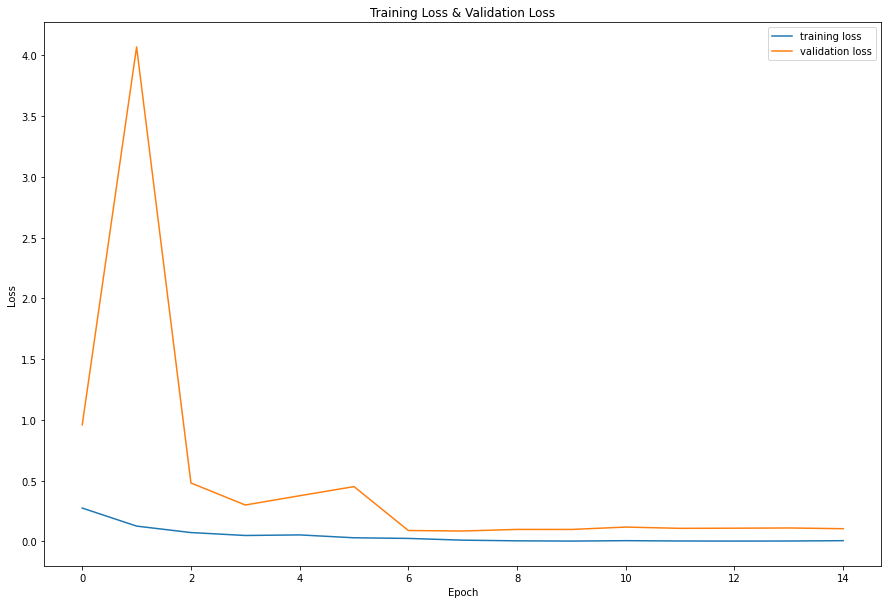

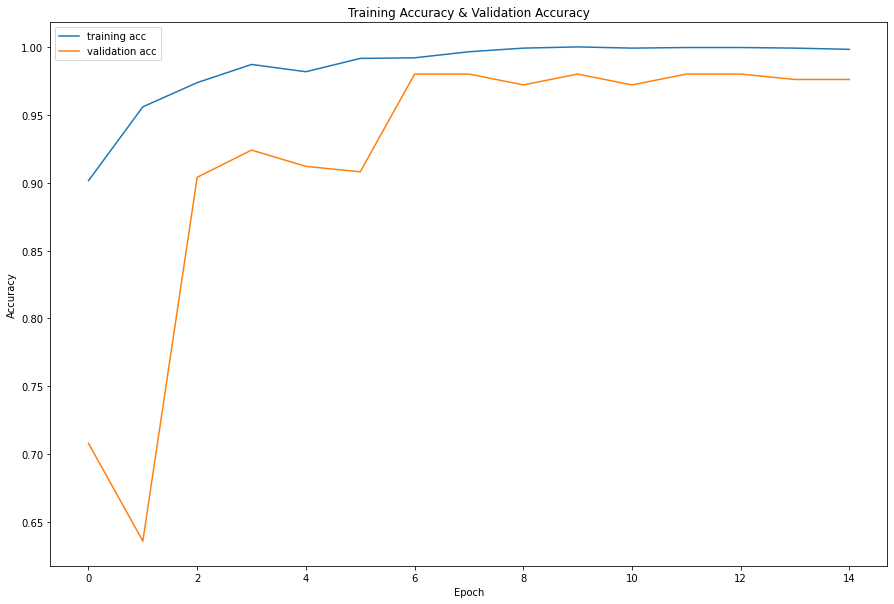

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(hist.history["loss"],label = "training loss")
plt.plot(hist.history["val_loss"],label = "validation loss")
plt.title("Training Loss & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(hist.history["accuracy"],label = "training acc")
plt.plot(hist.history["val_accuracy"],label = "validation acc")
plt.title("Training Accuracy & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# CLASSIFICATION REPORT

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      0.97      0.98        63
           2       0.98      1.00      0.99        93
           3       1.00      1.00      1.00        54

    accuracy                           0.99       278
   macro avg       0.99      0.99      0.99       278
weighted avg       0.99      0.99      0.99       278



# CONFUSION MATRIX

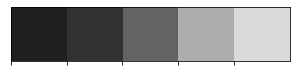

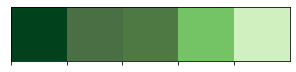

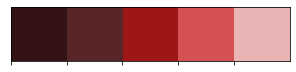

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

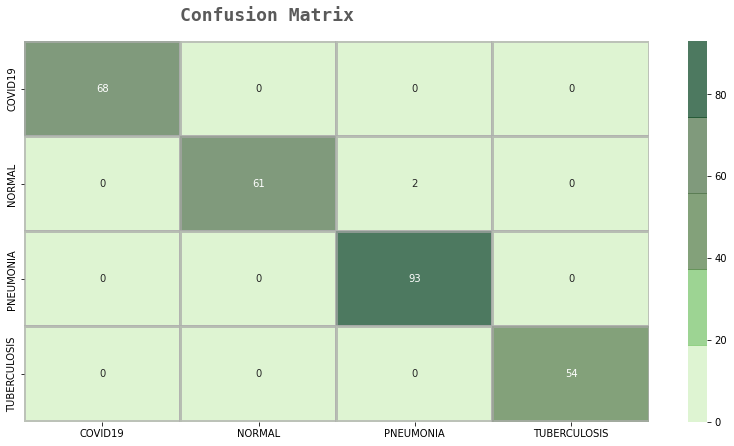

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))

sns.heatmap(confusion_matrix(y_test_new,pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,
            linewidths=2,
            linecolor=colors_dark[3]
            )

fig.text(s='Confusion Matrix',
         size=18,
         fontweight='bold',
         fontname='monospace',
         color=colors_dark[1],
         y=0.92,
         x=0.28,
         alpha=0.8)

plt.show()